In [105]:

import warnings
import pandas as pd
from utils.Copernicus import AdvancedCopernicus
import datetime
import os

# Ignore SettingWithCopyWarning:
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)



# Display all columns
pd.options.display.max_columns = None
#pd.options.display.max_rows = None

In [106]:
START_DATE = '2023-01-01'
# EndDate 7 Tage in die Zukunft
END_DATE = (datetime.datetime.now() + datetime.timedelta(days=2)).strftime('%Y-%m-%d %H:%M:%S') 

#END_DATE = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S') 
OUTPUT_FILENAME = 'output.nc'

BBOX= {
    # "min_lon":10.038345850696412,
    # "max_lon":10.365962458698567,
    # "min_lat":54.27381478077755,
    # "max_lat":54.52976525577923,

    "minimum_longitude":9.85083510071235,
    "maximum_longitude":10.926709174713364,
    "minimum_latitude":54.25206332481298,
    "maximum_latitude":54.97306793985031,

    "target_min_lon":10.156,
    "target_max_lon":10.170,
    "target_min_lat":54.354,
    "target_max_lat":54.365
    }

In [107]:
copernicus = AdvancedCopernicus()

def ouput_file_name(output_filename, minimum_longitude, maximum_longitude):
    output_range = maximum_longitude - minimum_longitude
    output_filename = f'{output_filename}-{START_DATE}-{output_range}.nc'
    return output_filename

def load_ocean_data(variables=["bottomT", "mlotst", "siconc", "sithick", "sla", "so", "sob", "thetao", "uo", "vo", "wo"],
                    minimum_longitude=BBOX["minimum_longitude"],
                    maximum_longitude=BBOX["maximum_longitude"],
                    minimum_latitude=BBOX["minimum_latitude"],
                    maximum_latitude=BBOX["maximum_latitude"],
                    delete_file=True,
                    output_filename='output'):

    output_filename = ouput_file_name(output_filename, minimum_longitude, maximum_longitude)
    print(f'Output File Name: {output_filename}')
    

    if os.path.exists(output_filename):
        print(f'File {output_filename} already exists')
        return output_filename

    data = copernicus.get_subset(
        dataset_id="cmems_mod_bal_phy_anfc_PT1H-i",
        dataset_version="202411",
        variables=variables,
        minimum_longitude=minimum_longitude,
        maximum_longitude=maximum_longitude,
        minimum_latitude=minimum_latitude,
        maximum_latitude=maximum_latitude,
        start_datetime=START_DATE,
        end_datetime=END_DATE,
        minimum_depth=0.5016462206840515,
        maximum_depth=0.5016462206840515,
        coordinates_selection_method="strict-inside",
        disable_progress_bar=False,
        output_filename=output_filename,
        delete_file=delete_file)

    return data.to_dataframe().reset_index()


df = load_ocean_data(
    variables=["sla"],
    minimum_longitude=BBOX["target_min_lon"],
    maximum_longitude=BBOX["target_max_lon"],
    minimum_latitude=BBOX["target_min_lat"],
    maximum_latitude=BBOX["target_max_lat"], delete_file=True, output_filename='Anomaly')





Output File Name: Anomaly-2023-01-01-0.013999999999999346.nc


INFO - 2025-03-10T13:19:37Z - Selected dataset version: "202411"
INFO - 2025-03-10T13:19:37Z - Selected dataset part: "default"
INFO - 2025-03-10T13:19:40Z - Starting download. Please wait...
100%|██████████| 8/8 [00:00<00:00, 10.35it/s]
INFO - 2025-03-10T13:19:41Z - Successfully downloaded to Anomaly-2023-01-01-0.013999999999999346.nc


In [108]:
df = df.groupby(by='time').mean().reset_index()
df

,time,latitude,longitude,sla
0,2023-01-01 00:00:00,54.358276,10.152689,-0.226056
1,2023-01-01 01:00:00,54.358276,10.152689,-0.182774
2,2023-01-01 02:00:00,54.358276,10.152689,-0.164800
3,2023-01-01 03:00:00,54.358276,10.152689,-0.140812
4,2023-01-01 04:00:00,54.358276,10.152689,-0.113516
...,...,...,...,...
19234,2025-03-12 10:00:00,54.358276,10.152689,-0.199664
19235,2025-03-12 11:00:00,54.358276,10.152689,-0.208965
19236,2025-03-12 12:00:00,54.358276,10.152689,-0.201083
19237,2025-03-12 13:00:00,54.358276,10.152689,-0.180635


Mean: -0.19434180855751038, Std: 0.2415529191493988


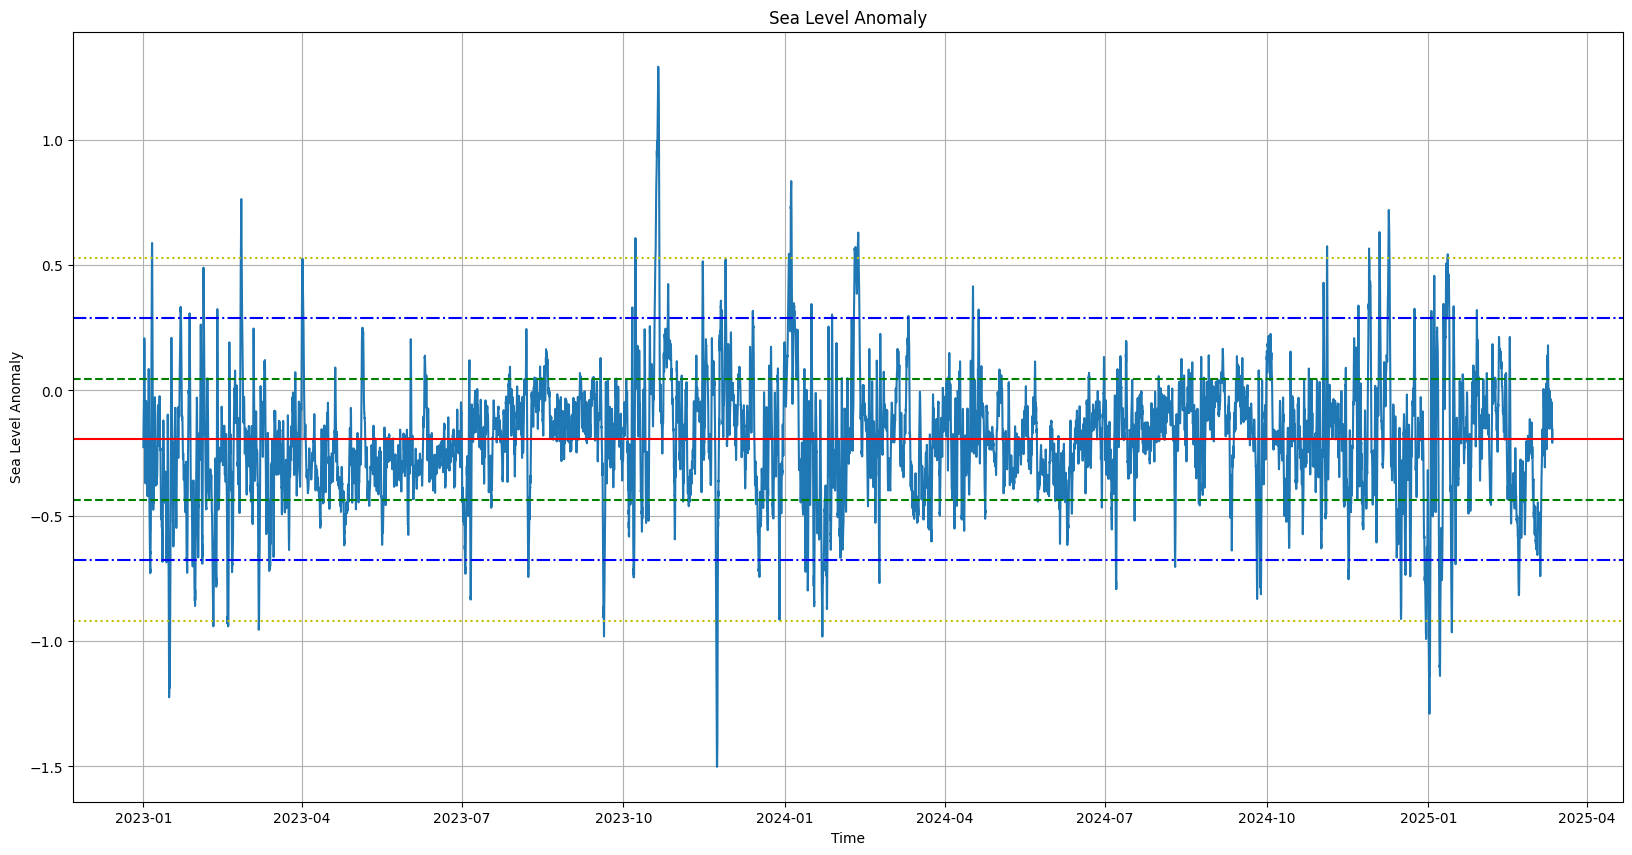

In [109]:
import matplotlib.pyplot as plt

sla_mean = df['sla'].mean()
sla_std = df['sla'].std()
print(f'Mean: {sla_mean}, Std: {sla_std}')

plt.figure(figsize=(20, 10))
plt.plot(df['time'], df['sla'])
plt.axhline(y=sla_mean, color='r', linestyle='-')
plt.axhline(y=sla_mean + sla_std, color='g', linestyle='--')
plt.axhline(y=sla_mean - sla_std, color='g', linestyle='--')
plt.axhline(y=sla_mean + 2*sla_std, color='b', linestyle='-.')
plt.axhline(y=sla_mean - 2*sla_std, color='b', linestyle='-.')
plt.axhline(y=sla_mean + 3*sla_std, color='y', linestyle=':')
plt.axhline(y=sla_mean - 3*sla_std, color='y', linestyle=':')
plt.title('Sea Level Anomaly')
plt.xlabel('Time')
plt.ylabel('Sea Level Anomaly')
plt.grid()
plt.show()

In [110]:

# Berechnung der Anomalie-Schwellenwerte
df['sla'] = df['sla'] + df['sla'].mean()

# Berechnung des Z-Scores für den Wasserstand (sla)
df['sla_mean'] = df['sla'].mean()
df['sla_std'] = df['sla'].std()
df['z_score'] = (df['sla'] - df['sla_mean']) / df['sla_std']

# Definition eines Schwellenwerts für Anomalien (z.B. Z-Score > 3 oder < -3)
threshold = 3
df['anomaly'] = (df['z_score'] > threshold) | (df['z_score'] < -threshold)

df['anomaly'] = (df['sla'] + abs(df['sla'].mean()) >= 1.0)
# Extraktion der Zeitpunkte, an denen Anomalien auftreten
anomalies = df[df['anomaly']]

# Ausgabe der Anomalien
display(anomalies[['time', 'sla', 'z_score']])

,time,sla,z_score
7003,2023-10-19 19:00:00,0.624659,4.195117
7004,2023-10-19 20:00:00,0.647823,4.291012
7005,2023-10-19 21:00:00,0.644895,4.278890
7006,2023-10-19 22:00:00,0.664191,4.358776
7007,2023-10-19 23:00:00,0.674818,4.402770
7008,2023-10-20 00:00:00,0.694297,4.483407
7009,2023-10-20 01:00:00,0.717309,4.578676
7010,2023-10-20 02:00:00,0.746113,4.697919
7011,2023-10-20 03:00:00,0.762430,4.765471
7012,2023-10-20 04:00:00,0.743853,4.688567


In [111]:
anomalies.loc[anomalies['z_score'] > 3, ['time', 'sla', 'z_score']].groupby(by='time').mean().reset_index()

,time,sla,z_score
0,2023-10-19 19:00:00,0.624659,4.195117
1,2023-10-19 20:00:00,0.647823,4.291012
2,2023-10-19 21:00:00,0.644895,4.278890
3,2023-10-19 22:00:00,0.664191,4.358776
4,2023-10-19 23:00:00,0.674818,4.402770
5,2023-10-20 00:00:00,0.694297,4.483407
6,2023-10-20 01:00:00,0.717309,4.578676
7,2023-10-20 02:00:00,0.746113,4.697919
8,2023-10-20 03:00:00,0.762430,4.765471
9,2023-10-20 04:00:00,0.743853,4.688567


In [112]:
import plotly.graph_objects as go
import pandas as pd
import datetime

# Aktuelles Datum bestimmen
today = datetime.datetime.today()


sla_mean = df['sla'].mean()

# Daten trennen: Vergangenheit vs. Zukunft
df_past = df[df['time'] <= today]
df_future = df[df['time'] > today]



# Identifikation von Anomalien mit Z-Score > 3
anomalies_grouped = anomalies.loc[anomalies['z_score'] > 3, ['time', 'sla', 'z_score']].groupby(by='time').mean().reset_index()

# Erstelle die Plotly-Figur
fig = go.Figure()

# Vergangenheit als durchgehende Linie
fig.add_trace(go.Scatter(
    x=df_past['time'], y=df_past['sla'], 
    mode='lines', name='Sea Level Anomaly (Past)', 
    line=dict(color='blue', dash='solid')
))

# Zukunft als gestrichelte Linie (Forecast)
fig.add_trace(go.Scatter(
    x=df_future['time'], y=df_future['sla'], 
    mode='lines', name='Sea Level Forecast', 
    line=dict(color='blue', dash='dash')
))

# Plot Mean 
fig.add_trace(go.Scatter(
    x=[df['time'].min(), df['time'].max()], y=[sla_mean, sla_mean],
    mode='lines', name='Mean',
    line=dict(color='red', dash='dash')
))

# Trennlinie für "Heute"
fig.add_trace(go.Scatter(
    x=[today, today], y=[df['sla'].min(), df['sla'].max()], 
    mode='lines', name='Today', 
    line=dict(color='black', dash='dot')
))

# Anomalien als rote Punkte
fig.add_trace(go.Scatter(
    x=anomalies_grouped['time'], y=anomalies_grouped['sla'], 
    mode='markers', name='Anomalies', 
    marker=dict(color='red', size=8)
))

# FARBBEREICHE für verschiedene Wasserstandshöhen
fig.add_shape(type="rect", x0=df['time'].min(), x1=df['time'].max(),
              y0=sla_mean + 1, y1=sla_mean + 1.25, fillcolor="yellow",
              opacity=0.3, layer="below", line_width=0, name='Low Anomaly')

fig.add_shape(type="rect", x0=df['time'].min(), x1=df['time'].max(),
              y0=sla_mean + 1.25, y1=sla_mean + 1.5, fillcolor="orange",
              opacity=0.3, layer="below", line_width=0)

fig.add_shape(type="rect", x0=df['time'].min(), x1=df['time'].max(),
              y0=sla_mean + 1.5, y1=sla_mean + 2, fillcolor="red",
              opacity=0.3, layer="below", line_width=0)

fig.add_shape(type="rect", x0=df['time'].min(), x1=df['time'].max(),
              y0=sla_mean + 2, y1=sla_mean + 2.5, fillcolor="darkred",
              opacity=0.3, layer="below", line_width=0)


fig.add_annotation(x=df['time'].median(), y=sla_mean + 1.125,
                   text="Strumflut", showarrow=False,
                   font=dict(size=12, color="black"),
                   bgcolor="yellow", opacity=0.7)

fig.add_annotation(x=df['time'].median(), y=sla_mean + 1.375,
                   text="mittlere Sturmflut", showarrow=False,
                   font=dict(size=12, color="black"),
                   bgcolor="orange", opacity=0.7)

fig.add_annotation(x=df['time'].median(), y=sla_mean + 1.75,
                   text="schwere Sturmflut", showarrow=False,
                   font=dict(size=12, color="white"),
                   bgcolor="red", opacity=0.7)

fig.add_annotation(x=df['time'].median(), y=sla_mean + 2.5,
                   text="sehr schwere Sturmflut", showarrow=False,
                   font=dict(size=12, color="white"),
                   bgcolor="darkred", opacity=0.7)


# Layout anpassen
fig.update_layout(
    title='Sea Level Anomaly with Forecast',
    xaxis_title='Time',
    yaxis_title='Sea Level Anomaly',
    width=1500,
    height=800,
    xaxis=dict(
        tickangle=45, 
        tickformat='%Y-%m-%d %H:%M:%S',
        showline=True,
        
        rangeslider=dict(visible=False),
        type='date'
    ),
    legend=dict(
        x=1.02,  # Position rechts außerhalb des Plots
        y=1,  
        xanchor='left',  # Legende am linken Rand der Position ausrichten
        yanchor='top',
        bgcolor='rgba(255,255,255,0.6)',  # Hintergrund für bessere Lesbarkeit
        bordercolor='black',
        borderwidth=1
    ),
    template='plotly_white'
)

fig.show()
